In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.sparse.linalg import cg
from scipy.sparse import diags

def initial_conditions(nx, ny, scenario='default'):
    """
    Sets initial conditions for the simulation based on the specified scenario.
    """
    field = np.zeros((ny, nx))
    if scenario == 'default':
        field[ny//4:3*ny//4, nx//4:3*nx//4] = 1.0
    elif scenario == 'circular':
        for y in range(ny):
            for x in range(nx):
                if (x - nx//2)**2 + (y - ny//2)**2 < (min(nx, ny)//4)**2:
                    field[y, x] = 1.0
    return field



In [2]:
def apply_boundary_conditions(field, bc_type="Dirichlet", value=0, axis=None):
    """
    Applies boundary conditions to a field.
    """
    if bc_type == "Dirichlet":
        if axis is None:
            field[0, :] = value
            field[-1, :] = value
            field[:, 0] = value
            field[:, -1] = value
        elif axis == 0:  # Apply along y-axis
            field[0, :] = value
            field[-1, :] = value
        elif axis == 1:  # Apply along x-axis
            field[:, 0] = value
            field[:, -1] = value
    elif bc_type == "Neumann":
        if axis is None:
            field[0, :] = field[1, :] + value
            field[-1, :] = field[-2, :] + value
            field[:, 0] = field[:, 1] + value
            field[:, -1] = field[:, -2] + value
        elif axis == 0:  # Apply along y-axis
            field[0, :] = field[1, :] + value
            field[-1, :] = field[-2, :] + value
        elif axis == 1:  # Apply along x-axis
            field[:, 0] = field[:, 1] + value
            field[:, -1] = field[:, -2] + value


In [3]:
def linear_convection(nx, ny, nt, dt, dx, dy, c_x=1.0, c_y=1.0):
    """
    Solves the linear convection equation.
    """
    u = np.ones((ny, nx))
    u[ny//4:3*ny//4, nx//4:3*nx//4] = 2  # Setting a square wave as the initial condition
    
    for n in range(nt):
        u_prev = u.copy()
        # Loop over the grid
        for j in range(1, ny):
            for i in range(1, nx):
                u[j, i] = (u_prev[j, i] - (c_x * dt / dx * (u_prev[j, i] - u_prev[j, i-1])) -
                           (c_y * dt / dy * (u_prev[j, i] - u_prev[j-1, i])))
    
    return u



In [4]:
def nonlinear_convection(nx, ny, nt, dt, dx, dy):
    """
    Solves the nonlinear convection equation.
    """
    u = np.ones((ny, nx))
    u[ny//4:3*ny//4, nx//4:3*nx//4] = 2  # Square wave initial condition
    
    for n in range(nt):
        u_prev = u.copy()
        # Loop over the grid
        for j in range(1, ny):
            for i in range(1, nx):
                u[j, i] = (u_prev[j, i] -
                           u_prev[j, i] * dt / dx * (u_prev[j, i] - u_prev[j, i-1]) -
                           u_prev[j, i] * dt / dy * (u_prev[j, i] - u_prev[j-1, i]))
    
    return u



In [5]:
def diffusion(nx, ny, nt, dt, dx, dy, nu=0.05):
    """
    Solves the diffusion equation.
    """
    u = np.ones((ny, nx))
    u[ny//4:3*ny//4, nx//4:3*nx//4] = 2  # Square wave initial condition
    
    for n in range(nt):
        u_prev = u.copy()
        # Loop over the grid
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                u[j, i] = (u_prev[j, i] + nu * dt / dx**2 * (u_prev[j, i+1] - 2 * u_prev[j, i] + u_prev[j, i-1]) +
                           nu * dt / dy**2 * (u_prev[j+1, i] - 2 * u_prev[j, i] + u_prev[j-1, i]))
    
    return u



In [6]:
def burgers_equation(nx, ny, nt, dt, dx, dy, nu=0.01):
    """
    Solves the Burgers' equation for a given set of parameters.
    """
    # Initialize the velocity field with ones
    u = np.ones((ny, nx))

    # Initial condition: a square wave
    u[ny//4:3*ny//4, nx//4:3*nx//4] = 2

    for n in range(nt):
        u_prev = u.copy()
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                u[j, i] = (u_prev[j, i] -
                           dt / dx * u_prev[j, i] * (u_prev[j, i] - u_prev[j, i-1]) +
                           nu * dt / dx**2 * (u_prev[j, i+1] - 2 * u_prev[j, i] + u_prev[j, i-1]) +
                           nu * dt / dy**2 * (u_prev[j+1, i] - 2 * u_prev[j, i] + u_prev[j-1, i]))
    return u




In [7]:
def laplace_equation(nx, ny, tol=1e-4):
    """
    Solves the Laplace equation.
    """
    # Initialize potential field
    phi = np.zeros((ny, nx))
    # Boundary conditions
    phi[:, 0] = 0  # Left
    phi[:, -1] = 0  # Right
    phi[0, :] = 0  # Bottom
    phi[-1, :] = 1  # Top (Dirichlet condition)
    
    iter_diff = tol + 1  # Initialize difference
    while iter_diff > tol:
        phi_prev = phi.copy()
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                phi[j, i] = 0.25 * (phi_prev[j, i+1] + phi_prev[j, i-1] +
                                    phi_prev[j+1, i] + phi_prev[j-1, i])
        iter_diff = np.max(np.abs(phi - phi_prev))
    
    return phi



In [8]:
def poisson_equation(nx, ny, source_strength=100.0, tol=1e-4):
    """
    Solves the Poisson equation.
    """
    # Initialize potential field
    phi = np.zeros((ny, nx))
    # Source term
    rho = np.zeros((ny, nx))
    rho[ny//2, nx//2] = source_strength  # Point source in the middle
    
    iter_diff = tol + 1  # Initialize difference
    while iter_diff > tol:
        phi_prev = phi.copy()
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                phi[j, i] = 0.25 * (phi_prev[j, i+1] + phi_prev[j, i-1] +
                                    phi_prev[j+1, i] + phi_prev[j-1, i] -
                                    dx**2 * rho[j, i])
        iter_diff = np.max(np.abs(phi - phi_prev))
    
    return phi



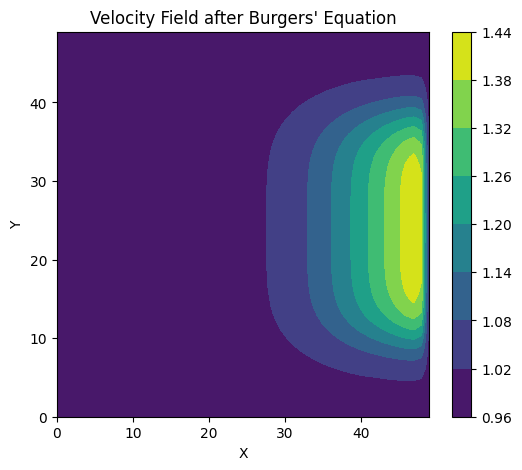

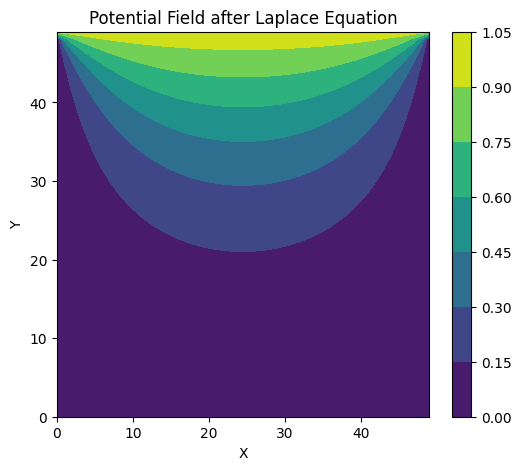

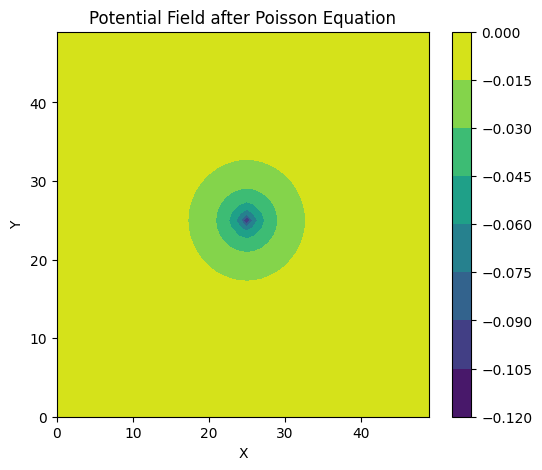

In [9]:
# Visualization helper
def plot_field(field, title="Field", cmap='viridis'):
    plt.figure(figsize=(6, 5))
    plt.contourf(field, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Example usage
nx, ny = 50, 50  # Adjust grid size for better resolution
dt = 0.01
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
nt = 100  # Number of time steps

u_burgers = burgers_equation(nx, ny, nt, dt, dx, dy)
plot_field(u_burgers, "Velocity Field after Burgers' Equation")

phi_laplace = laplace_equation(nx, ny)
plot_field(phi_laplace, "Potential Field after Laplace Equation")

phi_poisson = poisson_equation(nx, ny)
plot_field(phi_poisson, "Potential Field after Poisson Equation")


In [10]:
def build_up_b(rho, dt, dx, dy, u, v):
    b = np.zeros_like(u)
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx) + 
                     (v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, :-2]) / (2 * dx))**2 -
                    2 * ((u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy) *
                         (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx))-
                    ((v[2:, 1:-1] - v[:-2, 1:-1]) / (2 * dy))**2))
    return b

In [15]:
def pressure_poisson(p, dx, dy, b, nit=50):
    """
    Solves the pressure Poisson equation using the given parameters.
    """
    pn = np.empty_like(p)
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, :-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[:-2, 1:-1]) * dx**2) /
                         (2 * (dx**2 + dy**2)) -
                         dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                         b[1:-1, 1:-1])

        # Apply boundary conditions for p here as required by your problem setup

    return p



In [12]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    """
    Simulates fluid flow in a cavity using the Navier-Stokes equations.
    """
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros_like(u)
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(rho, dt, dx, dy, u, v)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, :-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, :-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1])))

        v[1:-1, 1:-1] = (vn[1:-1, 1:-1] -
                         un[1:-1, 1:-1] * dt / dx *
                        (vn[1:-1, 1:-1] - vn[1:-1, :-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) -
                         dt / (2 * rho * dy) * (p[2:, 1:-1] - p[:-2, 1:-1]) +
                         nu * (dt / dx**2 *
                        (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) +
                         dt / dy**2 *
                        (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1])))

        # Boundary conditions
        u[0, :] = 0
        u[:, 0] = 0
        u[:, -1] = 0
        u[-1, :] = 1    # Set velocity on cavity lid
        v[0, :] = 0
        v[-1, :]=0
        v[:, 0] = 0
        v[:, -1] = 0
        
    return u, v, p



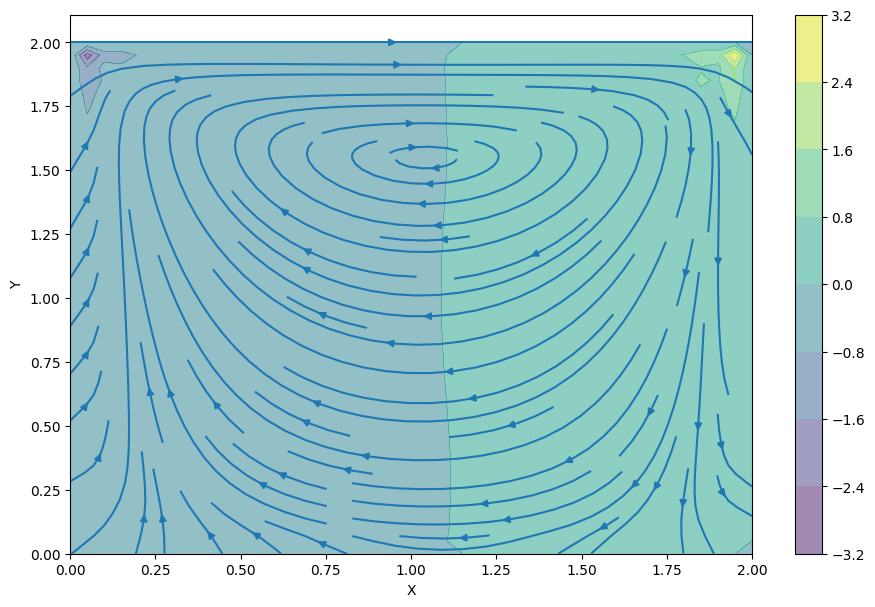

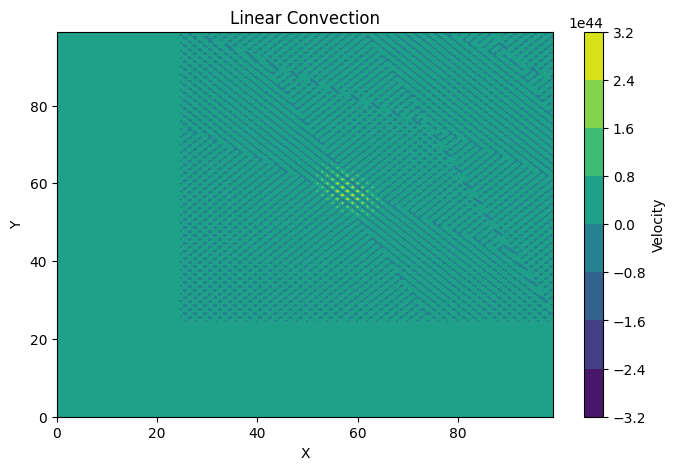

C:\Users\shrey\AppData\Local\Temp\ipykernel_36736\8146585.py:14: RuntimeWarning: overflow encountered in scalar multiply
  u_prev[j, i] * dt / dx * (u_prev[j, i] - u_prev[j, i-1]) -
C:\Users\shrey\AppData\Local\Temp\ipykernel_36736\8146585.py:15: RuntimeWarning: overflow encountered in scalar multiply
  u_prev[j, i] * dt / dy * (u_prev[j, i] - u_prev[j-1, i]))
C:\Users\shrey\AppData\Local\Temp\ipykernel_36736\8146585.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  u[j, i] = (u_prev[j, i] -
C:\Users\shrey\AppData\Local\Temp\ipykernel_36736\8146585.py:14: RuntimeWarning: invalid value encountered in scalar subtract
  u_prev[j, i] * dt / dx * (u_prev[j, i] - u_prev[j, i-1]) -
C:\Users\shrey\AppData\Local\Temp\ipykernel_36736\8146585.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  u_prev[j, i] * dt / dy * (u_prev[j, i] - u_prev[j-1, i]))


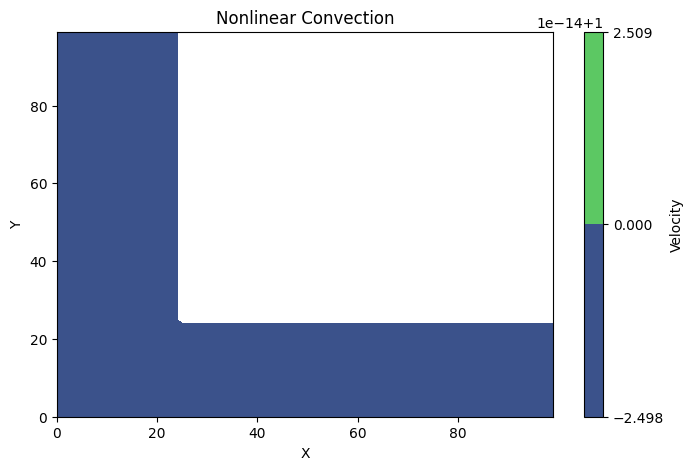

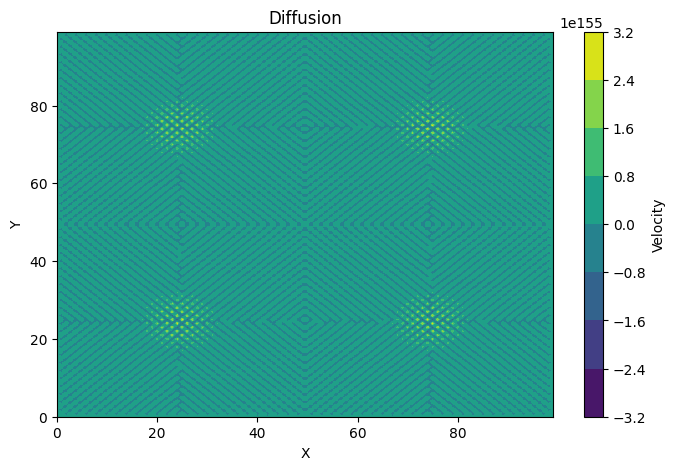

<Figure size 1000x600 with 0 Axes>

In [19]:
# Parameters
nx = 41
ny = 41
nt = 500
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = 0.1
dt = 0.001
x = np.linspace(0, 2, nx)  
y = np.linspace(0, 2, ny)  
X, Y = np.meshgrid(x, y)


u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))

# Run the simulation
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

# Visualization
fig = plt.figure(figsize=(11, 7), dpi=100)
# Contour plot for pressure
contour = plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar(contour)
# Streamplot for velocity
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


def plot_results(u, title='Velocity field'):
    plt.figure(figsize=(8, 5))
    plt.contourf(u, cmap='viridis')
    plt.colorbar(label='Velocity')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.show()

# Example usage
nx, ny = 100, 100
nt = 100
dt = 0.01
dx = 1.0 / (nx - 1)
dy = 1.0 / (ny - 1)

u_linear = linear_convection(nx, ny, nt, dt, dx, dy)
plot_results(u_linear, 'Linear Convection')

u_nonlinear = nonlinear_convection(nx, ny, nt, dt, dx, dy)
plot_results(u_nonlinear, 'Nonlinear Convection')

u_diffusion = diffusion(nx, ny, nt, dt, dx, dy)
plot_results(u_diffusion, 'Diffusion')


# Main execution function
def main():
    plt.figure(figsize=(10, 6))
    plt.show()

    

if __name__ == "__main__":
    main()
